# Data preprocessing

Functions for the catalysis reaction data preprocessing. The functions are quite ad hoc, and suited only for the raw data acquired from the Catalysis-hub and the CatApp catalysis reaction databases.

In [1]:
# Imports
import numpy as np
import pandas as pd
import json
import sys
import os
from ase.visualize import view
from ase.io import read
from ase import Atoms
from dscribe.descriptors import LMBTR

# Define the project root directory
ROOT_DIR = os.getcwd()

In [2]:
def load_json(filename):
    """
    Loads data from a Json file into pandas DataFrame.
    
    Params:
      filename (string):      Name of the Json datafile.
    Returns:
      df (pandas DataFrame):  The loaded data.
      None:                   If no data file is found.
    """
    
    with open(filename, "r") as file:
        data = json.load(file)
        df = pd.DataFrame()
        if "catapp" in filename:
            # Handle CatApp data
            for key in data:
                df = df.append(data[key], ignore_index=True)
        elif "cathub" in filename:
            # Handle Catalysis-hub data
            for key in data:
                df = df.append(data[key]["key_value_pairs"], ignore_index=True)
        else:
            print(f"No such file: {filename}")
            return None
    
    print(f"Loaded {len(data)} reactions from file {filename}")
    
    return df

In [3]:
def max_reactants_products(df, max_reactants, max_products):
    """
    Finds the maximum number of reactants and products in the reactions.

    Params:
      df (DataFrame):       The reaction data.
      max_reactants (int):  The current maximum number of reactants.
      max_products (int):   The current maximum number of products.
    Returns:
      (tuple of ints):      New maximum number of reactants and products,
                             respectively.
    """
    
    for r in df.reactants:
        rn = len(eval(r))
        if rn > max_reactants:
            max_reactants = rn
    for p in df.products:
        pn = len(eval(p))
        if pn > max_products:
            max_products = pn
    
    return max_reactants, max_products

In [4]:
def parse_reactants_products(df, db_name, max_reactants, max_products):
    """
    Parse the reaction data into a unified format.
    
    Params:
      df (DataFrame):       The raw data from a database as a pandas DataFrame.
      df_name (string):     The name of the database.
      max_reactants (int):  The maximum number of reactants in the data.
      max_products (int):   The maximum number of products in the data.
    Returns:
      df (DataFrame):       The parsed data as a pandas DataFrame.
    """
    
    # Create a list of column names
    col_names = []
    for i in range(max_reactants):
        col_names.append("reactant{}".format(i+1))
    for i in range(max_products):
        col_names.append("product{}".format(i+1))
    col_names.append("chemicalComposition")
    col_names.append("surfaceComposition")
    col_names.append("facet")
    col_names.append("sites")
    col_names.append("coverage")
    col_names.append("Equation")
    col_names.append("dftFunctional")
    col_names.append("reactionEnergy")
    col_names.append("activationEnergy")
        
    # Fill in the column values
    for i, row in df.iterrows():
        if db_name == "CatApp":
            # Handle CatApp data
            df.at[i, "reactant1"] = row.reactant_a
            df.at[i, "reactant2"] = row.reactant_b
            df.at[i, "product1"] = row.product_ab
            facet = row.reactant_facet
            surface = row.reactant_surface.replace(facet, "")
            facet = facet.split("(")[1].split(")")[0]
            df.at[i, "facet"] = facet
            df.at[i, "chemicalComposition"] = surface
            df.at[i, "sites"] = row.site
            df.at[i, "reactionEnergy"] = row.reaction_energy
            df.at[i, "activationEnergy"] = row.activation_energy
        elif db_name == "Catalysis-hub":
            # Handle Catalysis-hub data
            # Parse reactants
            reactants = list(eval(row.reactants))
            for j in range(len(reactants)):
                label = "reactant{}".format(j+1)
                df.at[i, label] = reactants[j]
            # Parse products
            products = list(eval(row.products))
            for j in range(len(products)):
                label = "product{}".format(j+1)
                df.at[i, label] = products[j]
            # Drop the deprecated columns
            # Parse adsorption site
            if row.sites != "None":
                sites = list(eval(row.sites).items())
                if len(sites) > 1:
                    print("WARNING: More than one site found!")
                if len(sites) > 0:
                    site = sites[0]
                    try:
                        site = "-".join(site)
                    except TypeError:
                        prefix = "-".join(site[1])
                        site = "-".join([site[0], prefix])
                else:
                    site = "None"
                df.at[i, "sites"] = site
            # Parse coverage
            if row.coverages != "None":
                coverage = list(eval(row.coverages).items())
                df.at[i, "coverages"] = coverages
            # Drop unneeded columns
            drop_names = ["dftCode", "id", "pubId", "username",
                          "reactants", "products"]
            for name in drop_names:
                try:
                    df = df.drop(name, axis=1)
                except KeyError:
                    pass
        else:
            print("Invalid database name")
    # Go through columns and record missing values
    for name in col_names:
        if name not in df:
            df[name] = "None"
    df = df[col_names]
    
    return df

In [5]:
# Load the Catalysis-hub and CatApp raw data
df_cathub_raw = load_json(f"{ROOT_DIR}/data/reactions_cathub.json")
df_catapp_raw = load_json(f"{ROOT_DIR}/data/reactions_catapp.json")

Loaded 1431 reactions from file /home/hlappal/projects/catalysis_data_project/data/reactions_cathub.json
Loaded 2306 reactions from file /home/hlappal/projects/catalysis_data_project/data/reactions_catapp.json


In [6]:
# Find the maximum number of reactants and products from the Catalysis-hub data.
# Note: The number of reactants/products is fixed in the CatApp data. This is why Catalysis-hub data is used.
max_reactants, max_products = max_reactants_products(df_cathub_raw, 0, 0)
print(f"Max reactants: {max_reactants}, Max products: {max_products}")

Max reactants: 3, Max products: 3


In [7]:
# Parse and combine the datasets
df_cathub_copy = parse_reactants_products(df_cathub_raw, "Catalysis-hub", max_reactants, max_products)
df_catapp_copy = parse_reactants_products(df_catapp_raw, "CatApp", max_reactants, max_products)
df = df_cathub_copy.append(df_catapp_copy, ignore_index=True, sort=False)

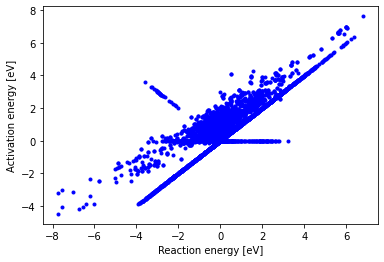

In [8]:
# Plot the data before cleaning
import matplotlib.pyplot as plt

plt.plot(df["reactionEnergy"], df["activationEnergy"], "b.")
plt.xlabel("Reaction energy [eV]")
plt.ylabel("Activation energy [eV]")
plt.savefig(f"{ROOT_DIR}/data/images/er_ea_correlation_raw.png")
plt.show()

### Clean up the data

In [9]:
# Unify notation
df = df.replace({"star": "*"}, regex=True)
df = df.replace({"gas": ""}, regex=True)
df = df.replace(np.nan, "None")

In [10]:
# Drop duplicate data points
shape = df.shape
df = df.drop_duplicates(ignore_index=True)
print(f"Removed {shape[0] - df.shape[0]} data points")

Removed 8 data points


In [11]:
# Find and drop empty columns
removed = []
for col in df.keys():
    if (df[col] == "None").all():
        df = df.drop(col, axis=1)
        removed.append(col)
print(f"Removed empty columns: {[col for col in removed]}")

Removed empty columns: ['coverage']


In [12]:
def rename_columns(df):
    """
    The function renames the columns into more readable form.
    
    Params:
      df (DataFrame):  The data.
    Returns:
      df (DataFrame):  The data.
    """
    
    df.rename(columns = {
        "reactant1": "Reactant 1",
        "reactant2": "Reactant 2",
        "reactant3": "Reactant 3",
        "product1": "Product 1",
        "product2": "Product 2",
        "product3": "Product 3",
        "chemicalComposition": "Chemical Composition",
        "surfaceComposition": "Surface Composition",
        "facet": "Facet",
        "sites": "Adsorption Site",
        "Equation": "Reaction Equation",
        "dftFunctional": "DFT Functional",
        "reactionEnergy": "Reaction Energy",
        "activationEnergy": "Activation Energy"
    }, inplace=True)
    
    return df

In [13]:
# Rename the columns
df = rename_columns(df)
df.head()

,Reactant 1,Reactant 2,Reactant 3,Product 1,Product 2,Product 3,Chemical Composition,Surface Composition,Facet,Adsorption Site,Reaction Equation,DFT Functional,Reaction Energy,Activation Energy
0,H2Oaq,H*,None,OHaq,*,H2,NaPt27H24O12,Pt,111,None,H2Oaq + H* -> H2(g) + OHaq + *,BEEF-vdW,1.584128,2.079705
1,*,H*,None,*,H2,None,NaPt27H24O12,Pt,111,None,H* + * -> H2(g) + 3*,BEEF-vdW,0.520276,0.618718
2,*,CH2C*,None,C*,CH2*,None,Ag30,Ag,111,None,CH2C* + * -> CH2* + C*,BEEF-vdW,3.701011,4.165724
3,N2,None,None,N*,None,None,Pt,Pt,211,None,N2(g) -> N*,RPBE,1.350000,2.550000
4,CO2*,None,None,CO2*,None,None,Au27NaH10O5,Au,211,CO2-H2O-topadiabatic,CO2* -> CO2*,RPBE,0.353636,0.482330


### Don't use reactions with improper activation energies

Removed 722 data points
Data shape: (3007, 14)


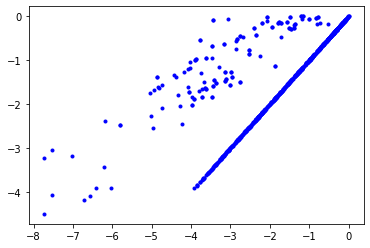

In [14]:
# Drop reactions with negative activation energy
negative_ea = df.iloc[np.where(df["Activation Energy"] < 0)]

for i in negative_ea.index:
    df = df.drop(i)
print(f"Removed {len(negative_ea.index)} data points")
print(f"Data shape: {df.shape}")
    
plt.plot(negative_ea["Reaction Energy"], negative_ea["Activation Energy"], "b.")
plt.show()

Removed 38 data points
Data shape: (2969, 14)


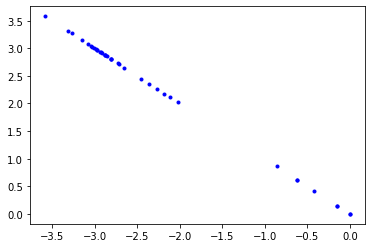

In [15]:
# Isolate the negatively linearly correlated data points
df_neg_linear = df.iloc[np.where(df["Reaction Energy"] == -df["Activation Energy"])]

for i in df_neg_linear.index:
    df = df.drop(i)
print(f"Removed {len(df_neg_linear.index)} data points")
print(f"Data shape: {df.shape}")

plt.plot(df_neg_linear["Reaction Energy"], df_neg_linear["Activation Energy"], "b.")
plt.show()

Removed 771 data points
Data shape: (2198, 14)


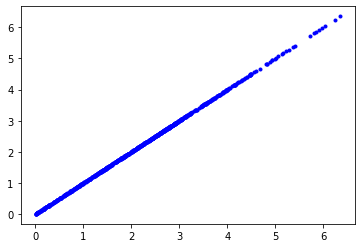

In [16]:
# Isolate the positively linearly correlated data points
df_pos_linear = df.iloc[np.where(df["Reaction Energy"] == df["Activation Energy"])]

for i in df_pos_linear.index:
    df = df.drop(i)
print(f"Removed {len(df_pos_linear.index)} data points")
print(f"Data shape: {df.shape}")

plt.plot(df_pos_linear["Reaction Energy"], df_pos_linear["Activation Energy"], "b.")
plt.show()

Removed 299 data points
Data shape: (1899, 14)


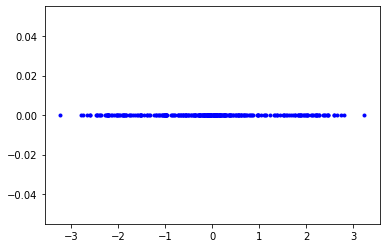

In [17]:
# Isolate the zero activation energy data points
df_zeros = df.iloc[np.where(df["Activation Energy"] == 0)]

for i in df_zeros.index:
    df = df.drop(i)
print(f"Removed {len(df_zeros.index)} data points")
print(f"Data shape: {df.shape}")

plt.plot(df_zeros["Reaction Energy"], df_zeros["Activation Energy"], "b.")
plt.show()

In [18]:
# Save the dataframe
df = df.reset_index(drop=True)
df.to_pickle(f"{ROOT_DIR}/data/data.csv")